In [146]:
import matplotlib.pyplot as plt
import os
import json
import cv2
import numpy as np
import mediapipe as mp
import skimage
from skimage.transform import PiecewiseAffineTransform, warp
import cv2
import mediapipe as mp
import skimage
from skimage.transform import PiecewiseAffineTransform, warp
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import mediapipe as mp
from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import face_mesh as mp_face_mesh

import imgaug.augmenters as iaa
import random
import re
import os
import shutil

In [147]:

LIPS = frozenset([
    # Lips.
    (61, 146),
    (146, 91),
    (91, 181),
    (181, 84),
    (84, 17),
    (17, 314),
    (314, 405),
    (405, 321),
    (321, 375),
    (375, 291),
    (61, 185),
    (185, 40),
    (40, 39),
    (39, 37),
    (37, 0),
    (0, 267),
    (267, 269),
    (269, 270),
    (270, 409),
    (409, 291),
    (78, 95),
    (95, 88),
    (88, 178),
    (178, 87),
    (87, 14),
    (14, 317),
    (317, 402),
    (402, 318),
    (318, 324),
    (324, 308),
    (78, 191),
    (191, 80),
    (80, 81),
    (81, 82),
    (82, 13),
    (13, 312),
    (312, 311),
    (311, 310),
    (310, 415),
    (415, 308)])
LEFT_EYE = frozenset([
    # Left eye.
    (263, 249),
    (249, 390),
    (390, 373),
    (373, 374),
    (374, 380),
    (380, 381),
    (381, 382),
    (382, 362),
    (263, 466),
    (466, 388),
    (388, 387),
    (387, 386),
    (386, 385),
    (385, 384),
    (384, 398),
    (398, 362) ])
LEFT_EYEBROW = frozenset([
    # Left eyebrow.
    (276, 283),
    (283, 282),
    (282, 295),
    (295, 285),
    (300, 293),
    (293, 334),
    (334, 296),
    (296, 336) ])
RIGHT_EYE = frozenset([
    # Right eye.
    (33, 7),
    (7, 163),
    (163, 144),
    (144, 145),
    (145, 153),
    (153, 154),
    (154, 155),
    (155, 133),
    (33, 246),
    (246, 161),
    (161, 160),
    (160, 159),
    (159, 158),
    (158, 157),
    (157, 173),
    (173, 133) ])
RIGHT_EYEBROW = frozenset([
    # Right eyebrow.
    (46, 53),
    (53, 52),
    (52, 65),
    (65, 55),
    (70, 63),
    (63, 105),
    (105, 66),
    (66, 107) ])
FACE_OVAL = frozenset([
    # Face oval.
    (10, 338),
    (338, 297),
    (297, 332),
    (332, 284),
    (284, 251),
    (251, 389),
    (389, 356),
    (356, 454),
    (454, 323),
    (323, 361),
    (361, 288),
    (288, 397),
    (397, 365),
    (365, 379),
    (379, 378),
    (378, 400),
    (400, 377),
    (377, 152),
    (152, 148),
    (148, 176),
    (176, 149),
    (149, 150),
    (150, 136),
    (136, 172),
    (172, 58),
    (58, 132),
    (132, 93),
    (93, 234),
    (234, 127),
    (127, 162),
    (162, 21),
    (21, 54),
    (54, 103),
    (103, 67),
    (67, 109),
    (109, 10)
])
# ln: 97,75,79,237,242,97
LEFT_NOSE = frozenset([
    # Left nose.
    (97,75),
    (75,79),
    (79,237),
    (237,242),
    (242,97)
])

# rn:328,376,354,274,305,328
RIGHT_NOSE = frozenset([

    (328,354),
    (354,274),
    (274,305),
    (305,289),
    (289,328)
])

UPPER_LIPS = frozenset([
    (61, 146),
    (146, 91),
    (91, 181),
    (181, 84),
    (84, 17),
    (17, 314),
    (314, 405),
    (405, 321),
    (321, 375),
    (375, 291),
    (61, 185),
    (185, 40),
    (40, 39),
    (39, 37),
    (37, 0),
    (0, 267),
    (267, 269),
    (269, 270),
    (270, 409),
    (409, 291),
])
LOWER_LIPS = frozenset([
    (78, 95),
    (95, 88),
    (88, 178),
    (178, 87),
    (87, 14),
    (14, 317),
    (317, 402),
    (402, 318),
    (318, 324),
    (324, 308),
    (78, 191),
    (191, 80),
    (80, 81),
    (81, 82),
    (82, 13),
    (13, 312),
    (312, 311),
    (311, 310),
    (310, 415),
    (415, 308)
])
NOSE = frozenset([
    #197,98,2,327,197
    #197,48,64,98,97,326,327,294,278
    (197,48),
    (48,64),
    (64,98),
    (98,97),
    (97,326),
    (326,327),
    (327,294),
    (294,278),
    (278,197)
    ])

EYE_BAG_LEFT = frozenset([
    #155,22,23,24,110,25,31,228,229,230,231,155
    (112,22),
    (22,23),
    (23,24),
    (24,110),
    (110,25),
    (25,31),
    (31,228),
    (228,229),
    (229,230),
    (230,231),
    (231,112)
])
EYE_BAG_RIGHT = frozenset([
    #453,253,254,339,255,261,448,449,450,451,453
    (453,253),
    (253,254),
    (254,339),
    (339,255),
    (255,261),
    (261,448),
    (448,449),
    (449,450),
    (450,451),
    (451,453)
])

FRECKLE_MASK = frozenset([
    #6,351,153,452,451,450,449,448,261,340,352,411,427,426,423,358, 19,237,129,203,206,207,187,123,228,229,230,231,233,122,6
    (6,351),
    (351,153),
    (153,452),
    (452,451),
    (451,450),
    (450,449),
    (449,448),
    (448,261),
    (261,340),
    (340,352),
    (352,411),
    (411,427),
    (427,426),
    (426,423),
    (423,358),
    (358, 19),
    (19,237),
    (237,129),
    (129,203),
    (203,206),
    (206,207),
    (207,187),
    (187,123),
    (123,228),
    (228,229),
    (229,230),
    (230,231),
    (231,233),
    (233,122),
    (122,6)

])

#6,451,261,372,345,433,416,434,432,411, 426,423,2,203,212,214,192,213,187,116, 35,228,231, 6 
BLUSH_MASK = frozenset([
    (6,451),
    (451,261),
    (261,372),
    (372,345),
    (345,433),
    (433,416),
    (416,434),
    (434,432),
    (432,426),
    (426,423),
    (423,2),
    (2,203),
    (203,212),
    (212,214),
    (214,192),
    (192,213),
    (213,116),
    (116,35),
    (35,228),
    (228,231),
    (231,6)
])


age_marks1 = frozenset([
    #70,111,123,138, 214,192,187,30,101,47,196,195,351,343,365,349,293,300,340,380,411,416,434,367
    70,111,123,138, 214,192,187,30,101,47,196,195,351,343,365,349,293,300,340,380,411,416,434,367
])


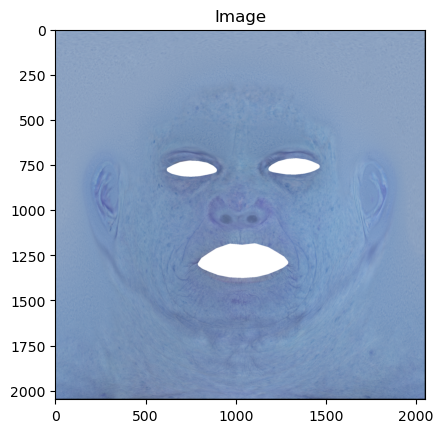

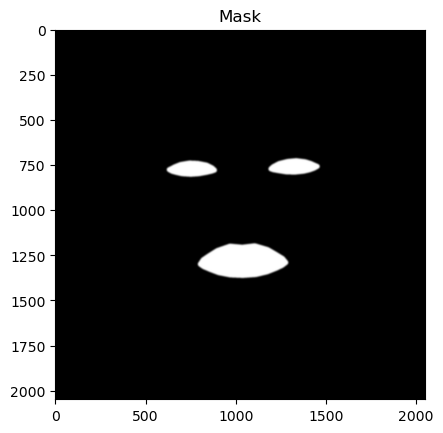

['BORDER_CONSTANT', 'BORDER_DEFAULT', 'BORDER_ISOLATED', 'BORDER_REFLECT', 'BORDER_REFLECT101', 'BORDER_REFLECT_101', 'BORDER_REPLICATE', 'BORDER_TRANSPARENT', 'BORDER_WRAP']


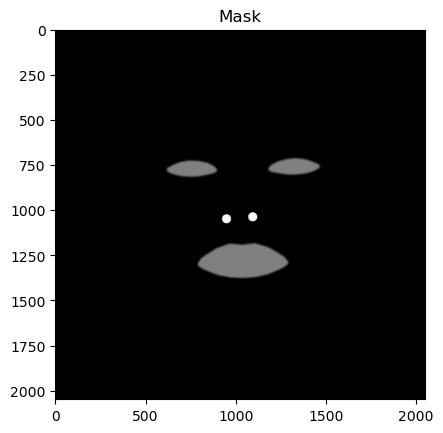

In [167]:
def draw_random_circles(base, color=(255,0,0), thickness=5):
    for i in range(0, 100):
        x = random.randint(0, base.shape[1])
        y = random.randint(0, base.shape[0])
        cv2.circle(base, (x,y), 5, color, thickness)
    return base

def draw_lines(image, face_landmarks, segments, color=(255,0,0), thickness=10):
    points = []
    for i in segments:
        p1 = i[0]
        p2 = i[1]
        p1x = int(face_landmarks.landmark[p1].x * image.shape[1])
        p1y = int(face_landmarks.landmark[p1].y * image.shape[0])
        p2x = int(face_landmarks.landmark[p2].x * image.shape[1])
        p2y = int(face_landmarks.landmark[p2].y * image.shape[0])
        points.append([p1x, p1y])
        points.append([p2x, p2y])
        #flood = fill_contour(image, color, (p1x, p1y))
        #poly line p1 to p2
        cv2.line(image, (p1x, p1y), (p2x, p2y), color, thickness=thickness)
        # cv2.polylines(image, np.array([points]), False, color, thickness=50)

    # Draw lines
    for i in range(0, len(points), 2):
        p1 = points[i]
        p2 = points[i + 1]
        cv2.line(image, p1, p2, color, thickness=25)
    #fill contour
    #seed = last point
    seed = points[-1]
    cv2.floodFill(image, None, seedPoint=(seed[0], seed[1]), newVal=color, loDiff=(0,0,0,0), upDiff=(0,0,0,0), flags=4 | cv2.FLOODFILL_MASK_ONLY)

    center = (sum([p[0] for p in points])//len(points), sum([p[1] for p in points])//len(points))

    return image
def draw_spots(image, face_landmarks, freckle_mask, color=(255,255,255), thickness=5):
    NOSE = set(range(4, 201))
    # Draw contour
    contour_points = []
    idx = 1
    for pair in freckle_mask:
        if idx % 2 == 0:
            continue
        idx += 1
        p1, p2 = pair
        x1, y1 = int(face_landmarks.landmark[p1].x * image.shape[1]), int(face_landmarks.landmark[p1].y * image.shape[0])
        x2, y2 = int(face_landmarks.landmark[p2].x * image.shape[1]), int(face_landmarks.landmark[p2].y * image.shape[0])
        contour_points.append([x1, y1])
        contour_points.append([x2, y2])
    contour_points = np.array(contour_points)

    # Draw spots on the landmarks
    for id, lm in enumerate(face_landmarks.landmark):
        shift = random.randint(-275, 275)
        shift_y = random.randint(0, 125)

        if id in UPPER_LIPS or id in LOWER_LIPS or id in LEFT_EYE or id in RIGHT_EYE:
            continue
        ih, iw, _ = image.shape
        x, y = int(lm.x * iw), int(lm.y * ih)
        #move x left or right
        y -= 750
        size = random.randint(1, 12)
        # 80% of spots inside contour, 20% outside
        if cv2.pointPolygonTest(contour_points, (x, y), False) >= 0 or random.random() < 0.1:
            if id in NOSE or id in LEFT_EYE or id in RIGHT_EYE:
                y += shift_y
                x += shift
            cv2.circle(image, (x, y), size, color, -1)  # -1 thickness makes circle filled

    return image

def draw_blemishes(image, face_landmarks, blemish_landmarks, color=(255,255,255), thickness=15):
    
    for id in blemish_landmarks:
        ih, iw, _ = image.shape
        lm = face_landmarks.landmark[id]
        x, y = int(lm.x * iw), int(lm.y * ih)
        x += random.randint(-400, 400)
        y += random.randint(-25, 25)
        y += random.randint(0, 125)

        size = random.randint(1, 24)  # random size for the blemish
        cv2.circle(image, (x, y), size, color, -1)  # -1 thickness makes circle filled
    return image

mask_directory = r"images"
color_dict = {
    'lips': (255, 0, 0),
    'eyes': (0, 255, 0),
    'nose': (0, 0, 255),
    'bags': (255,255,255)
}
# Load the image

# image_path = os.path.join(r"C:\\Users\\joeli\\Dropbox\\AE_InputModels\\", image_filename)
image_path = r"images/models_4k/m32.png"
image = cv2.imread(image_path)
mask = np.zeros_like(image)
#convert to RGB image
mask = np.zeros_like(image, dtype=np.uint8)
age_hemoglobin = np.zeros_like(image)
age_thickness = np.zeros_like(image)
# Flip the image horizontally for a later selfie-view display, and convert
# the BGR image to RGB.
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
annotated_image = image.copy()
ica_annnotated_image = image.copy()
mask = np.zeros(image.shape, dtype=np.uint8)

# Process the image with MediaPipe Face Mesh
with mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    min_detection_confidence=0.5) as face_mesh:

    results = face_mesh.process(image)

    face_landmarks = results.multi_face_landmarks[0]

    image= draw_lines(image, face_landmarks, LIPS,color=(255,255,255))
    image = draw_lines(image, face_landmarks, LEFT_EYE, color=(255,255,255))
    image = draw_lines(image, face_landmarks, RIGHT_EYE,color=(255,255,255))

    mask = draw_lines(mask, face_landmarks, LIPS, color=(255,255,255))
    mask = draw_lines(mask, face_landmarks, LEFT_EYE, color=(255,255,255))
    mask = draw_lines(mask, face_landmarks, RIGHT_EYE,color=(255,255,255))

    # Create color masks
    white_mask = cv2.inRange(image, (255, 255, 255), (255, 255, 255))

    # Find the contours in the masks
    white_contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    for contour in white_contours:
        cv2.drawContours(image, [contour], 0, (255, 255, 255), -1)
        cv2.drawContours(mask, [contour], 0, (255, 255, 255), -1)
    #gauusian blur mask
    mask = cv2.GaussianBlur(mask, (5,5), cv2.BORDER_DEFAULT)

    mask = cv2.GaussianBlur(mask, (15,15), cv2.BORDER_DEFAULT)
    #huge blur


   
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title('Image')
    plt.show()
    #save lips mask as just lips in black and white
    lips = np.zeros(image.shape, dtype=np.uint8)
    lips = draw_lines(lips, face_landmarks, LIPS, color=(255,255,255))
    lips = cv2.cvtColor(lips, cv2.COLOR_BGR2RGB)
    white_mask = cv2.inRange(lips, (255, 255, 255), (255, 255, 255))
    white_contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in white_contours:
        cv2.drawContours(lips, [contour], 0, (255, 255, 255), -1)
# landmark + coordinates x, y dict
landmark_locations = {}

with mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        refine_landmarks=True,
        max_num_faces=1,
        min_detection_confidence=0.6) as face_mesh:
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)

for face_landmarks in results.multi_face_landmarks:
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        # connections=mp_face_mesh.FACEMESH_TESSELATION,  # or FACEMESH_CONTOURS or FACEMESH_IRISES
        connections=None,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1),
    )

    index = 0
    for id, lm in enumerate(face_landmarks.landmark):
        ih, iw, _ = image.shape
        x, y = int(lm.x * iw), int(lm.y * ih)
        # cv2.putText(annotated_image, str(id), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .75, (0, 255, 0), 1)
        if id % 5 == 0:
            cv2.putText(annotated_image, str(id), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)
        landmark_locations[id] = (x, y)
# #draw white blemish at lm 250 and 60



plt.imshow(mask)
plt.title('Mask')
plt.show()
#gaussian blur mask with blurry edges
mask = cv2.GaussianBlur(mask, (5,5), cv2.BORDER_TRANSPARENT)
#add black fog to mask
mask = cv2.addWeighted(mask, 0.5, np.zeros_like(mask), 0.75, 0)
mask = cv2.GaussianBlur(mask, (5,5), cv2.BORDER_TRANSPARENT)
# random blend of mask and mask2
mask = cv2.addWeighted(mask, 0.5, mask, 0.5, 0)
mask = cv2.GaussianBlur(mask, (5,5), cv2.BORDER_TRANSPARENT)
xa, ya = landmark_locations[250]
xb, yb = landmark_locations[60]
cv2.circle(mask, (xa, ya), 25, (255,255,255), -1)
cv2.circle(mask, (xb, yb), 25, (255,255,255), -1)

#print boarder options
print([i for i in dir(cv2) if 'BORDER' in i])
plt.imshow(mask)
plt.title('Mask')
#save mask
plt.imsave("eye_lip_mask.png", mask)



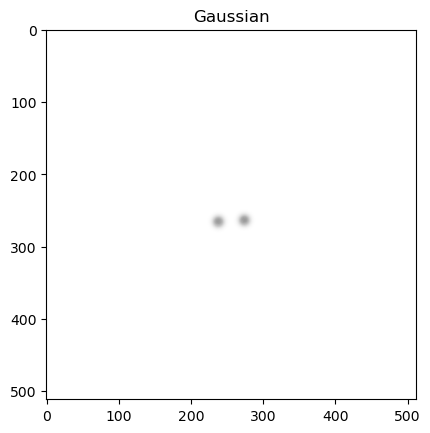

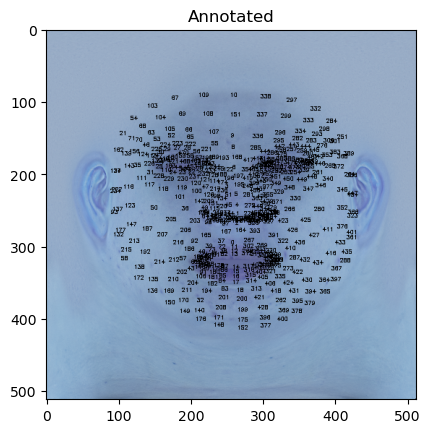

In [172]:
def gaussian_lighten(image, cx, cy, sigma, intensity):
    modified_image = image.copy()
    rows, cols, channels = modified_image.shape
    for x in range(rows):
        for y in range(cols):
            dist = np.sqrt((x - cx)**2 + (y - cy)**2)
            modified_image[x, y] += intensity * np.exp(-(dist**2) / (2 * sigma**2))
            # Clip the values to make sure they remain within the valid range
            modified_image[x, y] = np.clip(modified_image[x, y], 0, 1)
    return modified_image

def gaussian_darken(image, cx, cy, sigma, intensity):
    modified_image = image.copy()
    rows, cols, channels = modified_image.shape
    for x in range(rows):
        for y in range(cols):
            dist = np.sqrt((x - cx)**2 + (y - cy)**2)
            weight = 1 - np.exp(-(dist**2) / (2 * sigma**2))
            modified_image[x, y] += intensity * weight
            # Clip the values to make sure they remain within the valid range
            modified_image[x, y] = np.clip(modified_image[x, y], 0, 1)
    return modified_image
def gaussian(image, cx, cy, sigma, intensity):
    modified_image = image.copy()
    rows, cols, channels = modified_image.shape
    for x in range(rows):
        for y in range(cols):
            dist = np.sqrt((x - cx)**2 + (y - cy)**2)
            weight = 1 - np.exp(-(dist**2) / (2 * sigma**2))
            modified_image[x, y] -= intensity * weight
            # Clip the values to make sure they remain within the valid range
            modified_image[x, y] = np.clip(modified_image[x, y], 0, 1)
    return modified_image

Cm_path = r"images/old_lady/m32_Cm.png"
Ch_path = r"images/old_lady/m32_Ch.png"
image_path = r"images/models_4k/m141_4k.png"

#load Cm and Ch as binary images
Cm = plt.imread(Cm_path).astype(np.float32)
Ch = plt.imread(Ch_path).astype(np.float32)
image = plt.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#resize to 512x512
Cm = cv2.resize(Cm, (512, 512))
Ch = cv2.resize(Ch, (512, 512))
image = cv2.resize(image, (512, 512))
image = (image * 255).astype(np.uint8)
annotated_image = image.copy()
#landmark + coordinates x, y dict
landmark_locations = {}

with mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        refine_landmarks=True,
        max_num_faces=1,
        min_detection_confidence=0.6) as face_mesh:
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)

for face_landmarks in results.multi_face_landmarks:
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        # connections=mp_face_mesh.FACEMESH_TESSELATION,  # or FACEMESH_CONTOURS or FACEMESH_IRISES
        connections=None,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1),
    )

    index = 0
    for id, lm in enumerate(face_landmarks.landmark):
        ih, iw, _ = image.shape
        x, y = int(lm.x * iw), int(lm.y * ih)
        # cv2.putText(annotated_image, str(id), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .75, (0, 255, 0), 1)
        # if id % 5 == 0:
        # cv2.putText(annotated_image, str(id), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)
        cv2.putText(img=annotated_image, text=str(id), org=(x, y), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25, color=(0, 0, 0), thickness=1)
        landmark_locations[id] = (x, y)

# for lm,coordinates in landmark_locations.items():
#     x,y = coordinates
#     print(lm,x,y)

ya, xa = landmark_locations[250]
yb, xb = landmark_locations[60]

gaus = gaussian(Cm, xa,ya, 5, .5)
gaus = gaussian(gaus, xb, yb, 5, .5)

"""lmA = 187
lmB = 207
lmC = 214
#get center of triangle from 3 landmarks
avg_x = (landmark_locations[lmA][0] + landmark_locations[lmB][0] + landmark_locations[lmC][0]) / 3
avg_y = (landmark_locations[lmA][1] + landmark_locations[lmB][1] + landmark_locations[lmC][1]) / 3
print(avg_x,avg_y)
xA,yA = landmark_locations[lmA]
xB,yB = landmark_locations[lmB]
xC,yC = landmark_locations[lmC]
print(xA,yA)
print(xB,yB)
print(xC,yC)
#draw triangle on gaussian
cv2.line(gaus, (xA, yA), (xB, yB), (1, 1, 1), 1)
cv2.line(gaus, (xB, yB), (xC, yC), (1, 1, 1), 1)
cv2.line(gaus, (xC, yC), (xA, yA), (1, 1, 1), 1)
#draw average point
cv2.circle(gaus, (int(avg_x), int(avg_y)), 1, (1, 1, 1), 1)"""

"""age_spots = [70,111,123,138, 214,192,187,30,101,47,196,195,351,343,365,349,293,300,340,380,411,416,434,367]
for lm in age_spots:
    x,y = landmark_locations[lm]
    gaus = gaussian(gaus, x, y, 2, 1.0)"""

"""#pick 25 random landmarks between 1 and 400 y and x
for i in range(25):
    lm = random.randint(1,400)
    x,y = landmark_locations[lm]
    gaus = gaussian(gaus, x, y, 2, 1.0)"""



plt.imshow(gaus, cmap='binary', vmin=0, vmax=1)
plt.title('Gaussian')

plt.show()
plt.imshow(annotated_image)
plt.title('Annotated')
plt.show()
#save annotated image as high dpi
#convert to RGB image
#convert to RGB image
# annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imsave('images/old_lady/m32_annotated.png', annotated_image, dpi=1000)


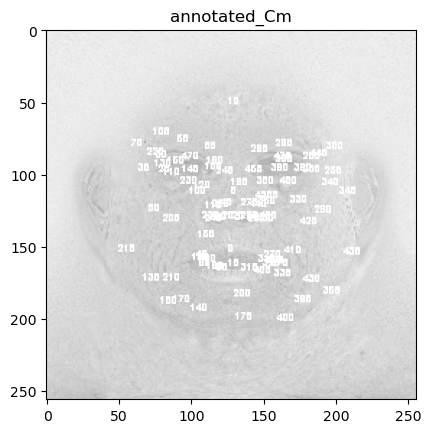

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


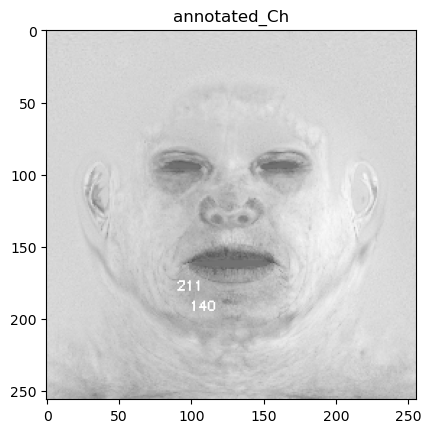

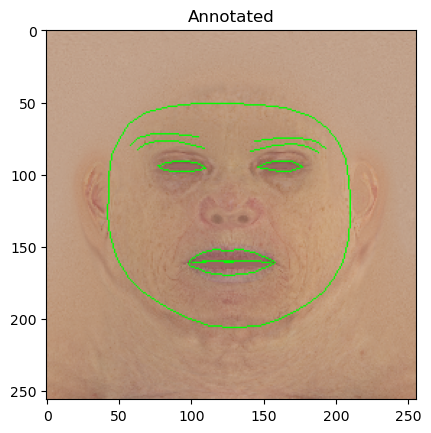

In [168]:
# def gaussian(image, cx, cy, sigma, intensity):
#     modified_image = image.copy()
#     rows, cols, channels = modified_image.shape
#     for y in range(rows):
#         for x in range(cols):
#             dist = np.sqrt((x - cx)**2 + (y - cy)**2)
#             modified_image[x, y] += intensity * np.exp(-(dist**2) / (2 * sigma**2))
#             # Clip the values to make sure they remain within the valid range
#             modified_image[x, y] = np.clip(modified_image[x, y], 0, 1)
#     return modified_image
def gaussian(image, cx, cy, sigma, intensity):
    modified_image = image.copy()
    rows, cols, channels = modified_image.shape
    for y in range(rows):  # switched y and x here
        for x in range(cols): # switched y and x here
            dist = np.sqrt((x - cx)**2 + (y - cy)**2)
            modified_image[y, x] += intensity * np.exp(-(dist**2) / (2 * sigma**2))
            # Clip the values to make sure they remain within the valid range
            modified_image[y, x] = np.clip(modified_image[y, x], 0, 1)
    return modified_image

Cm_path = r"images/old_lady/m32_Cm.png"
Ch_path = r"images/old_lady/m32_Ch.png"
image_path = r"images/models_4k/m32.png"

#load Cm and Ch as binary images
Cm = plt.imread(Cm_path).astype(np.float32)
Ch = plt.imread(Ch_path).astype(np.float32)
image = plt.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

width = 256
height = 256
#resize to 512x512
Cm = cv2.resize(Cm, (width, height))
Ch = cv2.resize(Ch, (width, height))
image = cv2.resize(image, (width, height))
image = (image * 255).astype(np.uint8)
annotated_image = image.copy()
annotated_Cm = Cm.copy()
#increase contrast annotated_Cm
# annotated_Cm = cv2.convertScaleAbs(annotated_Cm, alpha=1.5, beta=0)
annotated_Ch = Ch.copy()
#landmark + coordinates x, y dict
landmark_locations = {}
# age_marks = [70,111,123,138, 214,192,187,30,101,47,196,195,351,343,365,349,293,300,340,380,411,416,434,367]
# age_marks = age_marks[::2]
age_marks = [50,299,330]
# acne_marks = [32,58, 50,138, 136,199, 425, 287]
acne_marks = [211, 140]
with mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        refine_landmarks=True,
        max_num_faces=1,
        min_detection_confidence=0.6) as face_mesh:
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)

for face_landmarks in results.multi_face_landmarks:
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        # connections=mp_face_mesh.FACEMESH_TESSELATION,  # or FACEMESH_CONTOURS or FACEMESH_IRISES
        connections=mp_face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1),
    )

    index = 0
    for id, lm in enumerate(face_landmarks.landmark):
        ih, iw, _ = image.shape
        x,y = int(lm.x * iw), int(lm.y * ih)
        # cv2.putText(annotated_image, str(id), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .75, (0, 255, 0), 1)
        # if id % 5 == 0:
        # cv2.putText(annotated_image, str(id), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)
        landmark_locations[id] = (x,y)
        # cv2.putText(img=annotated_image, text=str(id), org=(x, y), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25, color=(0, 0, 0), thickness=1)
        if id % 5 == 0:
            # size = random.randint(1, 5)
            size = 5
            # annotated_Cm = gaussian(annotated_Cm, x,y, size, -0.25)
            cv2.putText(img=annotated_Cm, text=str(id), org=(x, y), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.2, color=(1,1,1), thickness=1)
        if id in acne_marks:
            # size = random.randint(1, 3)
            size = 3
            # annotated_Ch = gaussian(annotated_Ch, x,y, size, -0.25)
            cv2.putText(img=annotated_Ch, text=str(id), org=(x, y), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=(255,255,255), thickness=1)


# ya, xa = landmark_locations[250]
# yb, xb = landmark_locations[60]

##nostrils
# annotated_Cm = gaussian(annotated_Cm, xa,ya, 5, .5)
# annotated_Cm = gaussian(annotated_Cm, xb, yb, 5, .5)

# for lm in age_marks:
#     x,y = landmark_locations[lm]
#     annotated_Cm = gaussian(annotated_Cm, x, y, 3, -0.5)

# for lm in acne_marks:
#     x,y = landmark_locations[lm]
#     annotated_Ch = gaussian(annotated_Ch, x, y, 2, -0.5)

plt.imshow(annotated_Cm, cmap='viridis', vmin=0, vmax=1)
plt.title('annotated_Cm')
plt.show()

plt.imshow(annotated_Ch, cmap='viridis', vmin=0, vmax=1)
plt.title('annotated_Ch')
plt.show()
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(annotated_image)
plt.title('Annotated')
plt.show()
#save annotated image as high dpi
#convert to RGB image

# plt.imsave('images/old_lady/m32_annotated.png', annotated_image, dpi=1000)


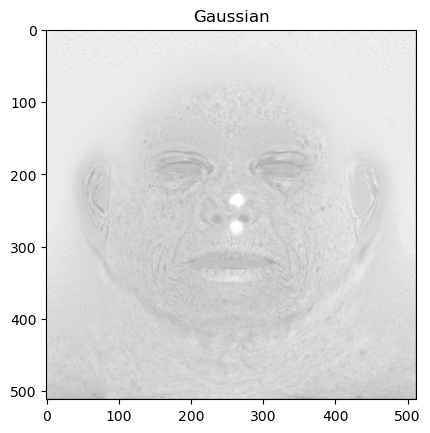

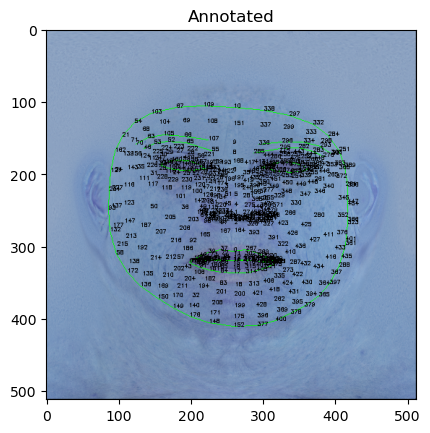

In [ ]:
def apply_gaussian(image, cx, cy, sigma, intensity):
    rows, cols, channels = image.shape
    y, x = np.ogrid[:rows, :cols]
    y = y - cy
    x = x - cx
    mask = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    mask = mask * intensity
    mask = np.repeat(mask[:, :, np.newaxis], channels, axis=2)
    modified_image = np.clip(image + mask, 0, 1) # Note the '+' instead of '-' for unified operation
    return modified_image



Cm_path = r"images/old_lady/m32_Cm.png"
Ch_path = r"images/old_lady/m32_Ch.png"
image_path = r"images/models_4k/m32.png"

#load Cm and Ch as binary images
Cm = plt.imread(Cm_path).astype(np.float32)
Ch = plt.imread(Ch_path).astype(np.float32)
image = plt.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#resize to 512x512
Cm = cv2.resize(Cm, (512, 512))
Ch = cv2.resize(Ch, (512, 512))
image = cv2.resize(image, (512, 512))
image = (image * 255).astype(np.uint8)
annotated_image = image.copy()
#landmark + coordinates x, y dict
landmark_locations = {}

with mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        refine_landmarks=True,
        max_num_faces=1,
        min_detection_confidence=0.6) as face_mesh:
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)

for face_landmarks in results.multi_face_landmarks:
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        # connections=mp_face_mesh.FACEMESH_TESSELATION,  # or FACEMESH_CONTOURS or FACEMESH_IRISES
        connections=mp_face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1),
    )

    index = 0
    for id, lm in enumerate(face_landmarks.landmark):
        ih, iw, _ = image.shape
        x, y = int(lm.x * iw), int(lm.y * ih)
        # cv2.putText(annotated_image, str(id), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .75, (0, 255, 0), 1)
        # if id % 5 == 0:
        # cv2.putText(annotated_image, str(id), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)
        cv2.putText(img=annotated_image, text=str(id), org=(x, y), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25, color=(0, 0, 0), thickness=1)
        landmark_locations[id] = (x, y)

ya, xa = landmark_locations[250]
yb, xb = landmark_locations[60]

# gaus = apply_gaussian(Cm, xa, ya, 5, -0.5) # Darken
# gaus = apply_gaussian(gaus, xb, yb, 5, -0.5) # Darken
gaus = apply_gaussian(Cm, xa, ya, 5, 0.5)  # Lighten
gaus = apply_gaussian(gaus, xb, yb, 5, 0.5)  # Lighten

plt.imshow(gaus, cmap='binary', vmin=0, vmax=1)
plt.title('Gaussian')

plt.show()
plt.imshow(annotated_image)
plt.title('Annotated')
plt.show()
#save annotated image as high dpi
#convert to RGB image
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imsave('images/old_lady/m32_annotated.png', annotated_image, dpi=1000)
